# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Import libraries

In [1]:
import cv2
from enum import Enum
import glob
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
import numpy as np
import os

## Camera calibration matrix and distortion coefficients

In [2]:
# Chessboard settings
class Chessboard:
    def __init__(self, nx=6, ny=8):
        self._nx = nx
        self._ny = ny


def display_corners(img, chessboard, corners, retval):
    cv2.drawChessboardCorners(
        img, 
        (chessboard._ny, chessboard._nx), 
        corners, 
        retval
    )
    cv2.imshow('img', img)
    cv2.waitKey(500)

        
def calibrate_camera(images, chessboard, show_corners=False):
    # Start preparing the object subspace (3d points in the real world space) and image subspace (2d points in the image plane) 
    obj_subspace = np.zeros((chessboard._nx*chessboard._ny,3), np.float32)
    obj_subspace[:,:2] = np.mgrid[0:chessboard._ny, 0:chessboard._nx].T.reshape(-1,2)

    obj_points = []
    img_points = []    
    
    # Step through the calibration images to search for chessboard corners
    for idx, image_name in enumerate(images):
        img = plt.imread(image_name)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        retval, corners = cv2.findChessboardCorners(
            gray, 
            (chessboard._ny, chessboard._nx), 
            None
        )
        if retval:
            obj_points.append(obj_subspace)
            img_points.append(corners)

            if show_corners:
                display_corners(img, chessboard, corners, retval)
                cv2.destroyAllWindows()

    # If there is an image in the images array, take it to compute the distortion matrix and coefficients
    if img is not None:
        img_size = (img.shape[1], img.shape[0])
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_size, None, None)  
        return (mtx, dist)
    else:
        raise ValueError("No calibration can be done from an empty image directory")
        

def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)    
    

chessboard = Chessboard(nx=6, ny=9)
images = glob.glob('camera_cal/calibration*.jpg')
distortion_mtx, distortion_coeffs = calibrate_camera(images, chessboard, show_corners=True)

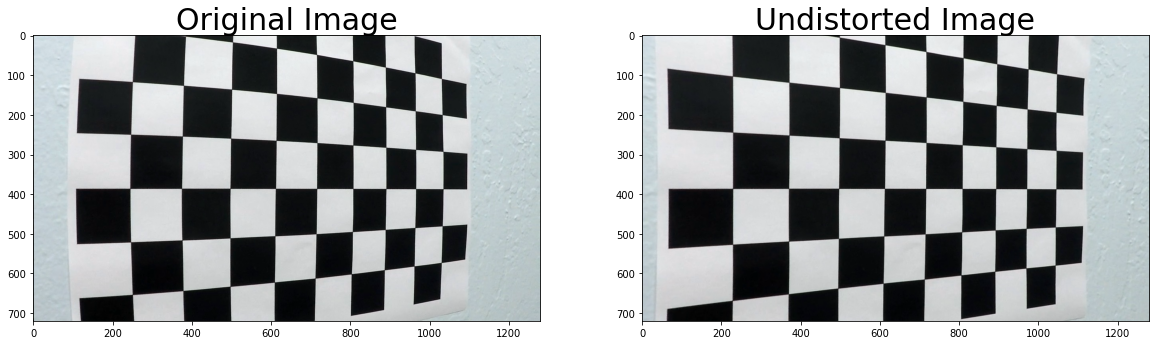

In [3]:
# Test undistortion on an chess image
img = cv2.imread('camera_cal/calibration5.jpg')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistort(img, distortion_mtx, distortion_coeffs))
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('output_images/undistorted_chessboard.jpg')

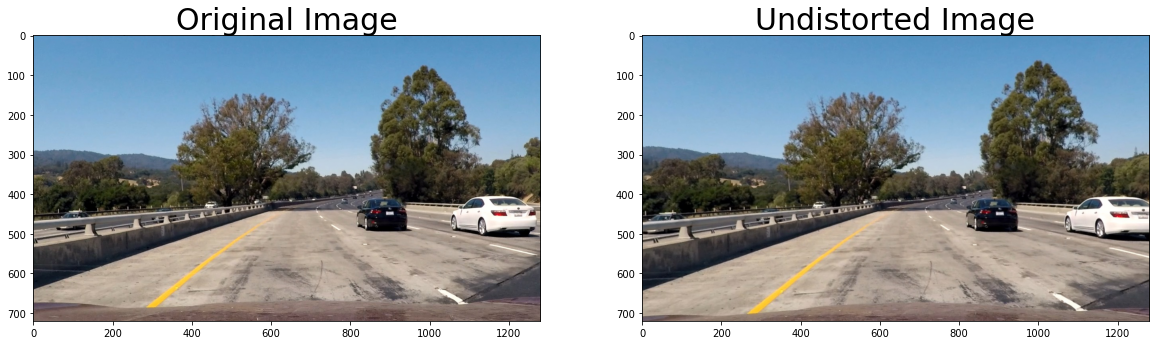

In [4]:
# Test undistortion on an road image
img = plt.imread('test_images/test1.jpg')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistort(img, distortion_mtx, distortion_coeffs))
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('output_images/undistorted_road_image.jpg')

## Thresholded binary image

In [5]:
def thresholded_image(img, sobel_x_threshold=(50, 255), s_threshold=(200, 255)):
    img = np.copy(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Apply the Sobel operator in the x direction
    sobel_x = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobel_x = np.absolute(sobel_x)
    scaled_sobel = np.uint8(255 * abs_sobel_x / np.max(abs_sobel_x))
    sobel_x_binary = np.zeros_like(scaled_sobel)
    sobel_x_binary[
        (scaled_sobel >= sobel_x_threshold[0]) & (scaled_sobel <= sobel_x_threshold[1])
    ] = 1
    
    # Threshold using the saturation channel
    saturation_binary = np.zeros_like(s_channel)
    saturation_binary[
        (s_channel >= s_threshold[0]) & (s_channel <= s_threshold[1])
    ] = 1

    # Combine the results
    color_binary = np.zeros_like(sobel_x_binary)
    color_binary[(sobel_x_binary == 1) | (saturation_binary == 1)] = 1
    return color_binary

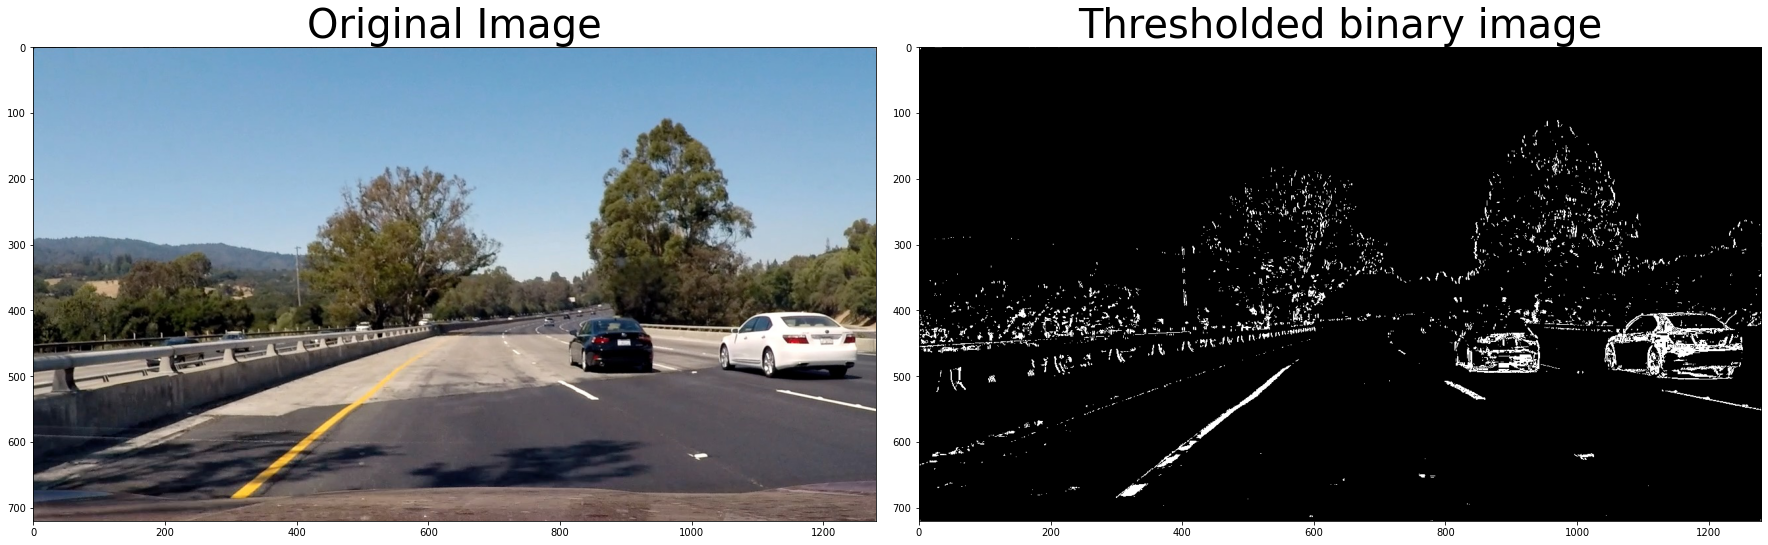

In [6]:
# Test thresholded binary image
img = plt.imread('test_images/test4.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(thresholded_image(img), cmap='gray')
ax2.set_title('Thresholded binary image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/thresholded_image.jpg')

## Perspective transform

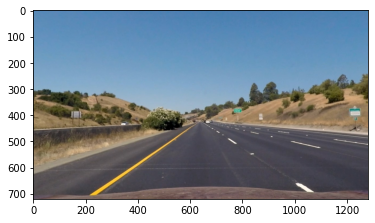

In [7]:
# Extract polygon vertices from a test_image
img = plt.imread("test_images/straight_lines1.jpg")
img_undist = undistort(img, distortion_mtx, distortion_coeffs)
plt.imshow(img_undist)

In [8]:
def warper(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img_undist, M, img_size, flags=cv2.INTER_LINEAR), M


# Hardcoded values taken from: 
# 1) lane lines pixels from the test_image, and
# 2) fine-tunning the resulting polygon in the image 
src = np.float32([
    [190, img.shape[0]],
    [550, 480],
    [735, 480],
    [1120, img.shape[0]]
])
dst = np.float32([
    [int(img.shape[1] // 4), img.shape[0]],
    [int(img.shape[1] // 4), 0],
    [int(img.shape[1] - img.shape[1] // 4), 0],
    [int(img.shape[1] - img.shape[1] // 4), img.shape[0]],
])

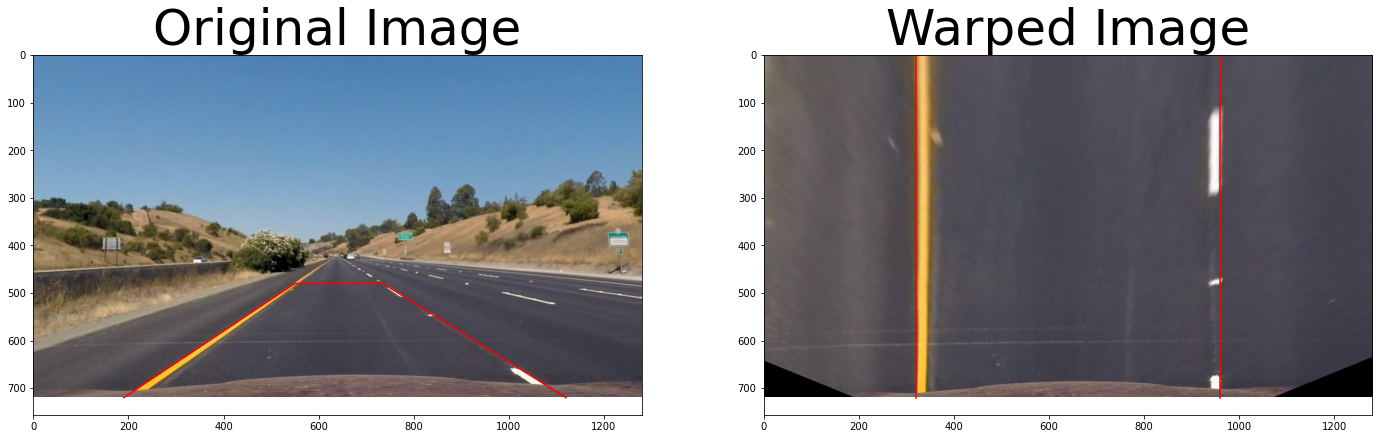

In [9]:
warped, M = warper(img, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img_undist)
ax1.plot(src.T[0], src.T[1], color='red')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.plot(dst.T[0], dst.T[1], color='red')
ax2.set_title('Warped Image', fontsize=50)
plt.savefig('output_images/warped_image.jpg')

## Fit lane line pixels with a polynomial

In [10]:
class Line():
    def __init__(self):
        self.frames = 10
        self.detected = []  # was the line detected in the last iteration?  
        self.recent_fits = []  # polynomial coefficients for the most recent fit
        self.recent_fits_world = []
        self.recent_x_fitted = []
        self.y_fitted = None

        self.x = None  # x values for detected line pixels
        self.y = None  # y values for detected line pixels
        self.xm_per_pix = None
        self.ym_per_pix = None

        # Using the last n iterations
        self.bestx = None  # average x values of the fitted line over the last n iterations
        self.best_fit = None  # polynomial coefficients averaged over the last n iterations
        self.best_fit_world = None 
        
        # Measurements
        self.radius_of_curvature = []  # radius of curvature of the line in m
        
    def update_best_fit(self):
        self.bestx = np.mean(self.recent_x_fitted, axis=0)
        self.best_fit = np.mean(self.recent_fits, axis=0)
        self.best_fit_world = np.mean(self.recent_fits_world, axis=0)
        
        if len(self.recent_x_fitted) > self.frames:
            del self.recent_x_fitted[0]
            del self.recent_fits[0]
            del self.recent_fits_world[0]
        return None

    def measure_curvature(self, y_bottom):
        self.radius_of_curvature.append((
            ((1 + (2 * self.best_fit_world[0] * y_bottom + self.best_fit_world[1]) ** 2) ** 1.5) / 
            (2 * np.absolute(self.best_fit_world[0]))
        ))
        if len(self.recent_x_fitted) > self.frames / 2:
            del self.radius_of_curvature[0]
        return np.mean(self.radius_of_curvature)

    def anormal_measurement(self, new_fit):
        if self.best_fit is None:
            return False
        std = np.std([self.best_fit, new_fit], axis=0)
        return True if std[1] > 0.3 else False


def fitted_x(fit, y):
    return fit[0] * y ** 2 + fit[1] * y + fit[2]


def fit_polynomial(img_shape, left_line, right_line):
    left_fit = np.polyfit(left_line.y, left_line.x, deg=2)
    right_fit = np.polyfit(right_line.y, right_line.x, deg=2)
    # Generate x and y values for plotting
    if left_line.anormal_measurement(left_fit) or right_line.anormal_measurement(right_fit):
        left_line.detected.append(False)
        right_line.detected.append(False)
        return left_line, right_line
    try:
        y_values = np.linspace(0, img_shape[0]-1, img_shape[0])
        
        left_line.detected.append(True)
        left_line.recent_x_fitted.append(fitted_x(left_fit, y_values))
        left_line.y_fitted = y_values
        left_line.recent_fits.append(left_fit)
        left_line.recent_fits_world.append(
            np.polyfit(left_line.y * left_line.ym_per_pix, left_line.x * left_line.xm_per_pix, deg=2)
        )
        
        right_line.detected.append(True)
        right_line.recent_x_fitted.append(fitted_x(right_fit, y_values))
        right_line.y_fitted = y_values
        right_line.recent_fits.append(right_fit)
        right_line.recent_fits_world.append(
            np.polyfit(right_line.y * right_line.ym_per_pix, right_line.x * right_line.xm_per_pix, deg=2)
        )
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still incorrect
        print('The function failed to fit a line!')
        left_line.detected.append(False)
        right_line.detected.append(False)
    return left_line, right_line

## Lane line pixels detection

In [11]:
def histogram_peaks(binary_img, target_line):
    histogram = np.sum(
        binary_img[binary_img.shape[0] // 2:, :], 
        axis=0
    )
    midpoint = np.int(histogram.shape[0] // 2)
    return np.argmax(histogram[:midpoint]) if target_line == "left" else np.argmax(histogram[midpoint:]) + midpoint
    

def indices_inside_window(x, y, centre_x, margin, win_y_low, win_y_high):
    return (
        (x >= centre_x - margin) & (x < centre_x + margin) & (y >= win_y_low) & (y < win_y_high)
    ).nonzero()[0]


def line_pixels_sliding_windows(binary_img, target_line="left"):    
    # HYPERPARAMETERS
    nwindows = 9
    margin = 100
    minpix = 30  # Minimum number of pixels found to recenter window
    window_height = np.int(binary_img.shape[0] // nwindows)
    
    # Identify the x and y positions of all activated pixels in the image
    activated_pixels = binary_img.nonzero()
    activated_pixels_y = np.array(activated_pixels[0])
    activated_pixels_x = np.array(activated_pixels[1])

    # Find the peak of the left and right halves of the histogram
    x_current = histogram_peaks(binary_img, target_line)

    # Create empty lists to receive lane pixel indices
    lane_inds = []
    for window in range(nwindows):
        win_y_low = binary_img.shape[0] - (window + 1) * window_height
        win_y_high = binary_img.shape[0] - window * window_height
        
        inds_inside_window = indices_inside_window(
            activated_pixels_x, activated_pixels_y, x_current, margin, win_y_low, win_y_high
        )
        lane_inds.append(inds_inside_window)
        
        # Recenter the window if appropiate
        if len(inds_inside_window) >  minpix:
            x_current = np.int(np.mean(activated_pixels_x[inds_inside_window]))
    
    # Concatenate the arrays of indices
    lane_inds = np.concatenate(lane_inds)

    # Extract left and right line pixel positions
    x = activated_pixels_x[lane_inds]
    y = activated_pixels_y[lane_inds] 
    return x, y


def lowerbound(fit, y, margin):
    return fitted_x(fit, y) - margin


def upperbound(fit, y, margin):
    return fitted_x(fit, y) + margin


def get_lane_inds(activated_pixels_x, activated_pixels_y, fit, margin):
    return (
        (activated_pixels_x > lowerbound(fit, activated_pixels_y, margin)) &
        (activated_pixels_x < upperbound(fit, activated_pixels_y, margin))
    )


def line_pixels_around_poly(binary_img, previous_line):
    # HYPERPARAMETER
    margin = 100  # margin around the previous polynomial to search

    # Grab activated pixels
    activated_pixels = binary_img.nonzero()
    activated_pixels_y = np.array(activated_pixels[0])
    activated_pixels_x = np.array(activated_pixels[1])
    
    # Extract previous line pixel positions
    lane_inds = get_lane_inds(activated_pixels_x, activated_pixels_y, previous_line.recent_fits[-1], margin)
    linex = activated_pixels_x[lane_inds]
    liney = activated_pixels_y[lane_inds] 

    return linex, liney


def lane_line_pixels_detection(binary_img, left_line, right_line, display_poly=False):
    out_img = np.dstack((binary_img, binary_img, binary_img))*255
    img_shape = (binary_img.shape[1], binary_img.shape[0])

    if len(left_line.recent_x_fitted) == 0:
        leftx, lefty = line_pixels_sliding_windows(binary_img, target_line="left")
    else:
        leftx, lefty = line_pixels_around_poly(binary_img, left_line)
    if len(right_line.recent_x_fitted) == 0:
        rightx, righty = line_pixels_sliding_windows(binary_img, target_line="right")
    else:
        rightx, righty = line_pixels_around_poly(binary_img, right_line)        
    
    left_line.x = leftx
    left_line.y = lefty
    right_line.x = rightx
    right_line.y = righty    

    # Fit new polynomials
    left_line, right_line = fit_polynomial(img_shape, left_line, right_line)
    left_line.update_best_fit()
    right_line.update_best_fit()
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[left_line.y, left_line.x] = [255, 0, 0]
    out_img[right_line.y, right_line.x] = [0, 0, 255]

    # Plot the polynomial lines onto the image
    if display_poly:
        plt.plot(left_line.bestx, left_line.y_fitted, color="green")
        plt.plot(right_line.bestx, right_line.y_fitted, color="green")
    
    return out_img, left_line, right_line

## Steps so far

Text(0.5, 1.0, 'Binary Image')

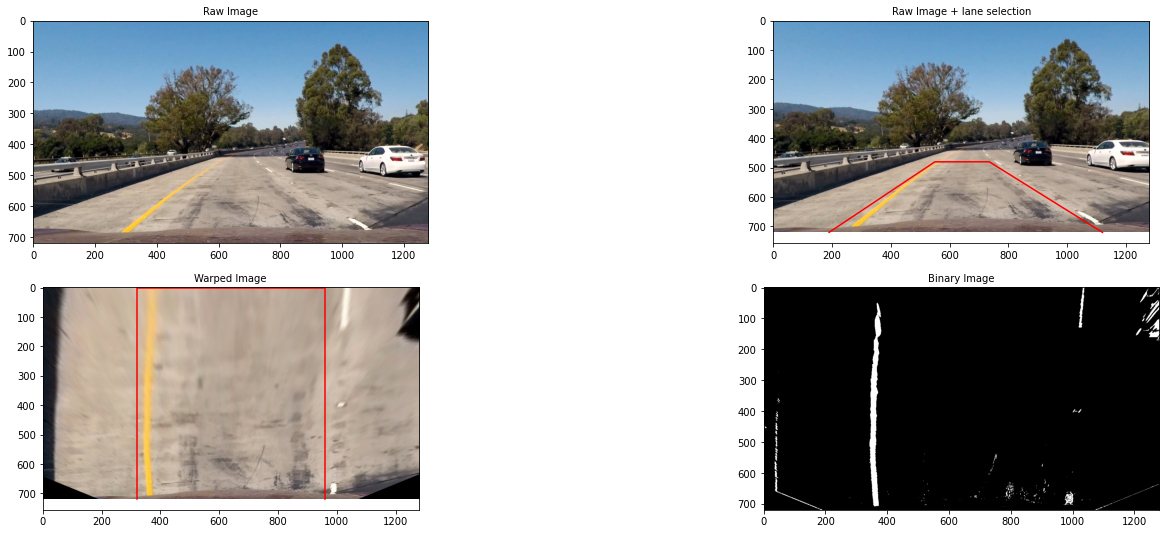

In [12]:
img = plt.imread("test_images/test1.jpg")
img_size = (img.shape[1], img.shape[0])
img_undist = undistort(img, distortion_mtx, distortion_coeffs)
warped_image, M = warper(img_undist, src, dst)
binary_image = thresholded_image(warped_image)

f, axs = plt.subplots(2, 2, figsize=(24, 9))
axs[0, 0].imshow(img)
axs[0, 0].set_title('Raw Image', fontsize=10)

axs[0, 1].imshow(img_undist)
axs[0, 1].plot(src.T[0], src.T[1], color='red')
axs[0, 1].set_title('Raw Image + lane selection', fontsize=10)

axs[1, 0].imshow(warped_image)
axs[1, 0].plot(dst.T[0], dst.T[1], color='red')
axs[1, 0].set_title('Warped Image', fontsize=10)

axs[1, 1].imshow(binary_image, cmap="gray")
axs[1, 1].set_title('Binary Image', fontsize=10)

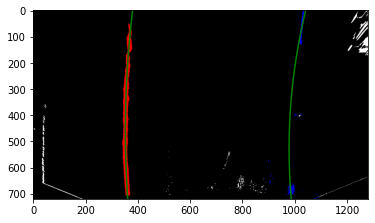

In [13]:
# Measurements taken from the course lectures
ym_per_pix = 30 / img_size[1]  # meters per pixel in y
xm_per_pix = 3.7 / (img_size[0] / 2)  # meters per pixel in x, the lane has half of the total width

left_line = Line()
right_line = Line()

left_line.xm_per_pix = xm_per_pix
right_line.xm_per_pix = xm_per_pix
left_line.ym_per_pix = ym_per_pix
right_line.ym_per_pix = ym_per_pix

img, left_line, right_line = lane_line_pixels_detection(binary_image, left_line, right_line, display_poly=True)
plt.imshow(img)

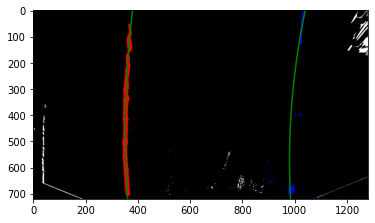

In [14]:
img, left_line, right_line = lane_line_pixels_detection(binary_image, left_line, right_line, display_poly=True)
plt.imshow(img)
plt.savefig('output_images/polyfit.jpg')

## Radius of curvature

In [15]:
left_curverad = left_line.measure_curvature(img_size[1] * ym_per_pix)
right_curverad = right_line.measure_curvature(img_size[1] * ym_per_pix)

print(left_curverad, right_curverad)

1157.794021313063 830.5435229207163


## Measure distance from lane centre

In [16]:
def distance_from_lane_centre(left_fit, right_fit, y_bottom, image_centre):
    x_bottom_left = left_fit[0] * y_bottom ** 2 + left_fit[1] * y_bottom + left_fit[2]
    x_bottom_right = right_fit[0] * y_bottom ** 2 + right_fit[1] * y_bottom + right_fit[2]
    lane_centre = x_bottom_right - x_bottom_left
    
    offset = lane_centre - image_centre
    return offset

distance_from_lane_centre(
    left_line.best_fit_world, 
    right_line.best_fit_world, 
    left_line.ym_per_pix * img_size[1], 
    left_line.xm_per_pix * img_size[0]/2
)

-0.10092302073391002

## Project the measurement back down onto the road

In [17]:
def warp_perspective(warped_img, undistorted_img, persp_matrix_inv, left_line, right_line):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line.bestx, left_line.y_fitted]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.bestx, right_line.y_fitted])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, persp_matrix_inv, (warped_img.shape[1], warped_img.shape[0])) 
    # Combine the result with the original image
    return cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)

## Pipeline projected

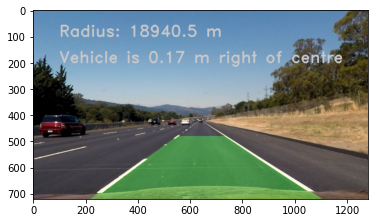

In [19]:
def detect_lane(img, distortion_mtx, distortion_coeffs, persp_matrix, persp_matrix_inv, left_line=Line(), right_line=Line(), display_measurements=False):    
    img_size = (img.shape[1], img.shape[0])
    xm_per_pix = 3.7 / (img_size[0] / 2)  # meters per pixel in x, the lane has half of the total width
    ym_per_pix = 30 / img_size[1]  # meters per pixel in y
    left_line.xm_per_pix = xm_per_pix
    right_line.xm_per_pix = xm_per_pix
    left_line.ym_per_pix = ym_per_pix
    right_line.ym_per_pix = ym_per_pix

    img_undist = undistort(img, distortion_mtx, distortion_coeffs)
    warped_image = cv2.warpPerspective(img_undist, M, img_size, flags=cv2.INTER_LINEAR)
    binary_image = thresholded_image(warped_image)    
    
    img, left_line, right_line = lane_line_pixels_detection(binary_image, left_line, right_line, display_poly=False)
    
    left_curverad = left_line.measure_curvature(img_size[1] * ym_per_pix)
    right_curverad = left_line.measure_curvature(img_size[1] * ym_per_pix)
    mean_radius = round((left_curverad + right_curverad) / 2, 1)
    
    offset_lane_centre = round(distance_from_lane_centre(
        left_line.best_fit_world, 
        right_line.best_fit_world, 
        left_line.ym_per_pix * img_size[1], 
        left_line.xm_per_pix * img_size[0]/2
    ), 2)
    
    unwarped_img = warp_perspective(binary_image, img_undist, persp_matrix_inv, left_line, right_line)
    if display_measurements:
        unwarped_img =cv2.putText(
            img=np.copy(unwarped_img), 
            text='Radius: ' + str(mean_radius) + " m", 
            org=(100,100),
            fontFace=2, 
            fontScale=2, 
            color=(200,200,200), 
            thickness=3
        )
        orientation = "right" if offset_lane_centre < 0 else "left"
        unwarped_img =cv2.putText(
            img=np.copy(unwarped_img), 
            text="Vehicle is " + str(np.absolute(offset_lane_centre)) + " m " + orientation + " of centre", 
            org=(100,200),
            fontFace=2, 
            fontScale=2, 
            color=(200,200,200), 
            thickness=3
        )        
    if not any(left_line.detected[-15:]):
        left_line = Line()
    if not any(right_line.detected[-15:]):
        right_line = Line()        
    return unwarped_img, left_line, right_line


left_line = Line()
right_line = Line()
persp_matrix = cv2.getPerspectiveTransform(src, dst)
persp_matrix_inv = cv2.getPerspectiveTransform(dst, src)

img = plt.imread("test_images/straight_lines2.jpg")
output = detect_lane(img, distortion_mtx, distortion_coeffs, persp_matrix, persp_matrix_inv, left_line, right_line, display_measurements=True)
plt.imshow(output[0])

In [20]:
# Save output images
test_images = os.listdir("test_images/")
for i in range(len(test_images)):
    img = plt.imread("test_images/" + test_images[i])
    print(test_images[i])
    left_line = Line()
    right_line = Line()
    output = detect_lane(img, distortion_mtx, distortion_coeffs, persp_matrix, persp_matrix_inv, left_line, right_line, display_measurements=True)
    mpimg.imsave('output_images/' + test_images[i], output[0])

test6.jpg
test4.jpg
test1.jpg
test5.jpg
straight_lines1.jpg
test3.jpg
straight_lines2.jpg
test2.jpg


## Tracking

In [20]:
left_line = Line()
right_line = Line()

def process_image(image):
    global left_line
    global right_line
    output = detect_lane(image, distortion_mtx, distortion_coeffs, persp_matrix, persp_matrix_inv, left_line, right_line, display_measurements=True)
    left_line = output[1]
    right_line = output[2]
    return output[0]


clip1 = VideoFileClip("project_video.mp4")
output = 'test_videos/project_video.mp4'
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos/project_video.mp4.
Moviepy - Writing video test_videos/project_video.mp4



Moviepy - Done !
Moviepy - video ready test_videos/project_video.mp4
CPU times: user 2min 50s, sys: 1min 5s, total: 3min 56s
Wall time: 1min 24s


In [21]:
left_line = Line()
right_line = Line()

def process_image(image):
    global left_line
    global right_line
    output = detect_lane(image, distortion_mtx, distortion_coeffs, persp_matrix, persp_matrix_inv, left_line, right_line, display_measurements=True)
    left_line = output[1]
    right_line = output[2]
    return output[0]


clip1 = VideoFileClip("challenge_video.mp4")
output = 'test_videos/challenge_video.mp4'
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

t:   1%|          | 3/485 [00:00<00:19, 24.57it/s, now=None]

Moviepy - Building video test_videos/challenge_video.mp4.
Moviepy - Writing video test_videos/challenge_video.mp4



Moviepy - Done !
Moviepy - video ready test_videos/challenge_video.mp4
CPU times: user 1min, sys: 22.8 s, total: 1min 23s
Wall time: 30.2 s
